In [17]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [18]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/isBigBrain_ukb_without_residualization.csv"
label = "isBigBrain"
max_iter = 2000
cv = 5

In [19]:
participants = pd.read_csv(participants_file, index_col=0)
participants

,Sex,Age,BrainVolumeFreeSurfer_mm3,Ageattendedimaging,ImagingName,isBigBrain,isOld
participant_id,,,,,,,
sub-3411469,1,65.0,1136465.0,65.0,Cheadle,NaN,NaN
sub-2290292,0,69.0,1079118.0,69.0,Newcastle,NaN,NaN
sub-3842391,0,70.0,1124077.0,70.0,Cheadle,NaN,NaN
sub-2758537,1,49.0,1246758.0,49.0,Newcastle,NaN,0.0
sub-4334619,1,70.0,1410387.0,70.0,Cheadle,1.0,NaN
...,...,...,...,...,...,...,...
sub-2621329,1,56.0,1260788.0,56.0,Cheadle,NaN,NaN
sub-5057890,1,72.0,1328760.0,72.0,Cheadle,NaN,NaN
sub-2038574,1,70.0,1244624.0,70.0,Reading,NaN,NaN


In [33]:
participants = pd.read_csv(participants_file, index_col=0)
participants = participants[["Sex", "BrainVolumeFreeSurfer_mm3", label]].dropna()

In [34]:
participants

,Sex,BrainVolumeFreeSurfer_mm3,isBigBrain
participant_id,,,
sub-4334619,1,1410387.0,1.0
sub-5767106,1,1385492.0,1.0
sub-1188492,0,997615.0,0.0
sub-3405143,1,1383324.0,1.0
sub-1502040,1,1346017.0,1.0
...,...,...,...
sub-4241819,1,1378101.0,1.0
sub-1981949,1,1351739.0,1.0
sub-1936273,1,1371857.0,1.0


(array([ 296.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3554.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

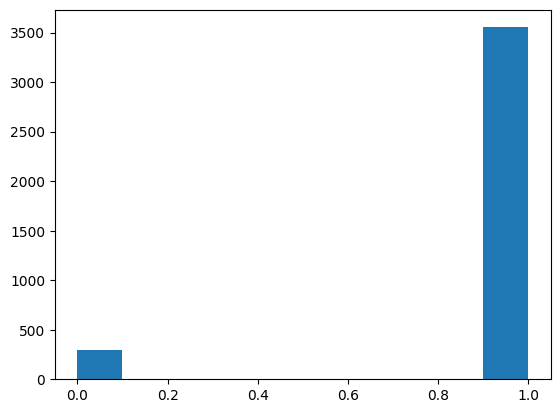

In [35]:
plt.hist(participants[participants.Sex==1]["isBigBrain"])

In [36]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return np.argsort((points-point)**2)[:10]

In [37]:
participants

,Sex,BrainVolumeFreeSurfer_mm3,isBigBrain
participant_id,,,
sub-4334619,1,1410387.0,1.0
sub-5767106,1,1385492.0,1.0
sub-1188492,0,997615.0,0.0
sub-3405143,1,1383324.0,1.0
sub-1502040,1,1346017.0,1.0
...,...,...,...
sub-4241819,1,1378101.0,1.0
sub-1981949,1,1351739.0,1.0
sub-1936273,1,1371857.0,1.0


In [46]:
females = participants[(participants.Sex == 0) & (participants.isBigBrain == 0)].copy()
males = participants[(participants.Sex == 1) & (participants.isBigBrain == 0)].copy()

females["chosen"] = 0
for one_male in males.iloc[:,1]:
    chosen_rows = closest_point(one_male, females.iloc[:,1])
    for chosen_row in chosen_rows:
        if females.iloc[chosen_row, 3] == 0:
            females.iloc[chosen_row, 3] = 1
            break

participants_smallbrain = pd.concat([males, females[females.chosen==1][["Sex", "BrainVolumeFreeSurfer_mm3"]]])

In [49]:
females = participants[(participants.Sex == 0) & (participants.isBigBrain == 1)].copy()
males = participants[(participants.Sex == 1) & (participants.isBigBrain == 1)].copy()

males["chosen"] = 0
for one_female in females.iloc[:,1]:
    chosen_rows = closest_point(one_male, females.iloc[:,1])
    for chosen_row in chosen_rows:
        if females.iloc[chosen_row, 3] == 0:
            females.iloc[chosen_row, 3] = 1
            break

participants_smallbrain = pd.concat([males, females[females.chosen==1][["Sex", "BrainVolumeFreeSurfer_mm3"]]])

,Sex,BrainVolumeFreeSurfer_mm3,isBigBrain
participant_id,,,
sub-2214448,1,1012144.0,0.0
sub-1045691,1,1041322.0,0.0
sub-5365179,1,1031106.0,0.0
sub-4539455,1,980312.0,0.0
sub-2641978,1,1003269.0,0.0
...,...,...,...
sub-2666797,0,981198.0,NaN
sub-2148124,0,973410.0,NaN
sub-5177527,0,1019422.0,NaN


In [4]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [5]:
model_paths = get_model_paths(path_champollion)

In [6]:
model_paths

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/11-43-38_3',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/13-19-08_28',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/Lobule_parietal_sup_left/09-48-31_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFint-SR_left/09-00-43_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SPoC_left/18-08-26_0',
 '/neurospin/dico/data/deep_folding/current/mod

In [7]:
def compute(model_path):
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    
    # Classifies
    X = merged.drop(label, axis=1)
    Y = merged[label]
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    model = LogisticRegression(max_iter=max_iter, random_state=1)
    res = cross_val_score(model, X, Y, cv=cv, scoring='roc_auc')
    
    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(res)
    
    # Returns result
    return (region, res.mean(), res.std(), model_name, region_path, model_path)

In [8]:
result = []
for model_path in model_paths:
    result.append(compute(model_path))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
[0.7823183  0.74829394 0.77231926 0.78191816 0.80656639]
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
[0.78561749 0.75840929 0.77935468 0.76343199 0.78753033]
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
[0.81433411 0.79107042 0.82224648 0.82638687 0.83515284]
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
[0.9054126  0.88589981 0.8986657  0.89056283 0.87463206]
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
[0.949

In [9]:
df = pd.DataFrame(result, columns=['region', 'roc_auc', 'roc_auc_std', 'model_name', 'region_path', 'model_path'])

In [10]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path
0,S.C.-sylv._left,0.778283,0.018785,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,0.774869,0.011813,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.817838,0.014974,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,0.891035,0.010589,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,0.944716,0.003787,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
71,S.F.inter.-S.F.sup._right,0.834425,0.018698,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
72,S.T.s._left,0.844863,0.006814,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
73,F.C.M.post.-S.p.C._right,0.776602,0.014961,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
74,ORBITAL_right,0.891908,0.009157,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [11]:
df['side'] = df['region'].str.split('_').str[-1]

In [15]:
def plot_horizontal(res, region_name, ax, AUC_name, std_auc_name, AUC2_name, std_auc2_name, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=AUC_name, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.5, color='black', linestyle='-')
    ax.barh(res[region_name], res[AUC2_name], fill=True, color='lightgray')
    ax.errorbar(res[AUC_name], res[region_name], xerr=res[std_auc_name], fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    ax.set_xlim((0.45, 1.0))
    ax.set_title(title)


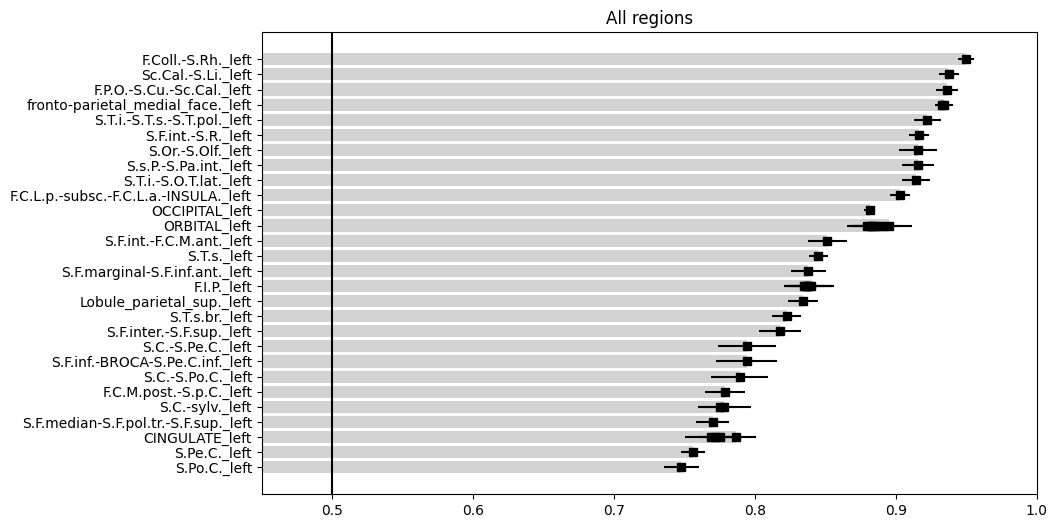

In [16]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

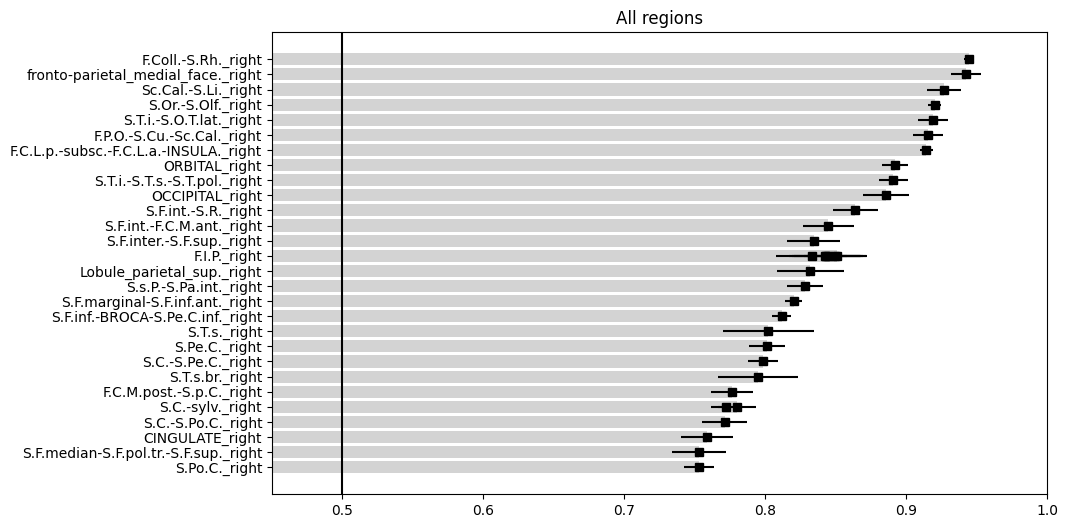

In [17]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "roc_auc", "roc_auc_std", "roc_auc", "roc_auc_std", True, "All regions")
plt.show()

In [18]:
df

,region,roc_auc,roc_auc_std,model_name,region_path,model_path,side
0,S.C.-sylv._left,0.778283,0.018785,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,0.774869,0.011813,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.817838,0.014974,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,0.891035,0.010589,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,0.944716,0.003787,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
71,S.F.inter.-S.F.sup._right,0.834425,0.018698,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
72,S.T.s._left,0.844863,0.006814,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
73,F.C.M.post.-S.p.C._right,0.776602,0.014961,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
74,ORBITAL_right,0.891908,0.009157,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [22]:
df.to_csv(output_filename)